# Legit or Misinformative?



# Data Sources

## Kaggle
https://www.kaggle.com/datasets/vishakhdapat/fake-news-detection
https://www.kaggle.com/datasets/nitishjolly/news-detection-fake-or-real-dataset



## Wikipedia

## Google Fact Check
https://toolbox.google.com/factcheck/apis

## FEVER
https://fever.ai/dataset/averitec.html
has training and test datasets

### Averitech challenge
https://fever.ai/task.html

Github query: https://github.com/search?q=Fact+Extraction+and+VERification+%28FEVER%29&type=repositories&s=updated&o=desc

Hugging Face repo: https://huggingface.co/chenxwh/AVeriTeC

## Search for NLP veracity checking
https://github.com/kianfattahy/Text-Veracity-Classification

https://www.mdpi.com/2411-9660/5/3/42

opinion phrases: https://vladsandulescu.com/opinion-phrases/?utm_content=buffer56740&utm_medium=social&utm_source=twitter.com&utm_campaign=buffer

## spaCy

https://spacy.io/

## Semantic analysis to extract facts from test article(s)

### Using spaCy

In [2]:


import spacy
nlp = spacy.load("en_core_web_md")


In [4]:
text = "The Eiffel Tower is located in Paris. It was constructed in 1889."
doc = nlp(text)
doc


The Eiffel Tower is located in Paris. It was constructed in 1889.

In [13]:
# extract named entities
for ent in doc.ents:
    print(ent.text, '\t| ', ent.label_, '\t| ', spacy.explain(ent.label_))


The Eiffel Tower 	|  FAC 	|  Buildings, airports, highways, bridges, etc.
Paris 	|  GPE 	|  Countries, cities, states
1889 	|  DATE 	|  Absolute or relative dates or periods


In [19]:
# parse dependencies
for token in doc:
    print(token.text)
    if token.dep_ in ['nsubj', 'attr', 'acomp'] and token.head.pos_ in ['VERB', 'AUX']:
        print(token.text, token.head.text, [child for child in token.children])


The
Eiffel
Tower
was
built
by
Gustave
Eiffel
.


In [25]:
from spacy.matcher import Matcher

# Load spaCy and create a Matcher instance
nlp = spacy.load('en_core_web_md')
matcher = Matcher(nlp.vocab)

# Define a comprehensive list of patterns
patterns = [
    # Simple Subject-Verb-Object (SVO)
    [{'DEP': 'nsubj'}, {'POS': 'VERB'}, {'DEP': 'dobj'}],
    # Subject-Verb-Adjective (SVA)
    [{'DEP': 'nsubj'}, {'POS': 'VERB'}, {'DEP': 'acomp'}],
    # Subject-Verb-Prepositional Phrase (SVPP)
    [{'DEP': 'nsubj'}, {'POS': 'VERB'}, {'POS': 'ADP', 'OP': '?'}, {'DEP': 'pobj'}],
    # Passive Voice (Agent-Verb-Subject)
    [{'DEP': 'agent'}, {'POS': 'VERB'}, {'DEP': 'nsubjpass'}],
    # Adjectives or attributes linked to subjects
    [{'DEP': 'nsubj'}, {'POS': 'VERB'}, {'DEP': 'attr'}],
    # Handling conjunctions in factual statements
    [{'DEP': 'nsubj'}, {'POS': 'VERB'}, {'POS': 'CCONJ', 'OP': '?'}, {'DEP': 'conj'}],
    # Extended phrases involving adverbs or auxiliary verbs
    [{'DEP': 'nsubj'}, {'POS': 'AUX', 'OP': '?'}, {'POS': 'ADV', 'OP': '?'}, {'POS': 'VERB'}, {'DEP': 'dobj'}]
]

# Add patterns to the matcher
for i, pattern in enumerate(patterns):
    matcher.add(f"FACT_ASSERTION_{i}", [pattern])




In [26]:
texts = [
    "The Eiffel Tower was constructed by Gustave Eiffel.",
    "Quantum mechanics is a branch of physics.",
    "Albert Einstein developed the theory of relativity in the early 20th century.",
    "The heart pumps blood through the body.",
    "Paris, the capital of France, is known for its culture.",
    "Coffee is grown extensively in Brazil."
]

for text in texts:
    doc = nlp(text)
    matches = matcher(doc)
    for match_id, start, end in matches:
        span = doc[start:end]  # The matched span
        print(f"Factual assertion found: {span.text}")


Factual assertion found: heart pumps blood
Factual assertion found: heart pumps blood


In [31]:
from spacy import displacy

text = "Quantum mechanics is a branch of physics."
doc = nlp(text)
displacy.serve(doc, style='dep',auto_select_port=True)  # This will open a web server to visually inspect the sentence



Using the 'dep' visualizer
Serving on http://0.0.0.0:5001 ...

Shutting down server on port 5001.


# Moving on
This seems like a rabbit hole!  I'll assume that further work could get the assertion finder working.  I'm switching to building the classifier, and will use the averitech dataset to do that.

# Building a classifier

I'll follow the form of the Averitech task.  

### Datasets
https://fever.ai/dataset/averitec.html
has training and test datasets


In [32]:
## Load in the Datasets
import pandas as pd

# Load the dataset
df_dev = pd.read_json('data/data_dev.json')
df_train = pd.read_json('data/data_train.json')
df_test = pd.read_json('data/data_test.json')

# Display the first few rows of the dataset
df_dev.head()



,claim,required_reannotation,label,justification,claim_date,speaker,original_claim_url,fact_checking_article,reporting_source,location_ISO_code,claim_types,fact_checking_strategies,questions,cached_original_claim_url
0,"In a letter to Steve Jobs, Sean Connery refuse...",False,Refuted,The answer and sources show that the claim was...,31-10-2020,None,None,https://web.archive.org/web/20201130144023/htt...,Facebook,None,[Event/Property Claim],[Written Evidence],[{'question': 'Where was the claim first publi...,None
1,Trump Administration claimed songwriter Billie...,False,Refuted,Seems that the Wzshington post accused the sin...,31-10-2020,None,None,https://web.archive.org/web/20201103001419/htt...,Instagram,US,"[Position Statement, Event/Property Claim]",[Written Evidence],[{'question': 'Has the Trump administration vo...,None
2,Due to Imran Khan's criticism of Macron's comm...,False,Refuted,The tweet was not the official government page...,31-10-2020,Consulate General Of Pakistan France,https://web.archive.org/web/20201113115127/htt...,https://web.archive.org/web/20210629013122/htt...,Twitter,FR,"[Causal Claim, Event/Property Claim]",[Written Evidence],[{'question': 'How did Macron criticise Islam?...,https://web.archive.org/web/20201113115127/htt...
3,UNESCO declared Nadar community as the most an...,False,Refuted,This claim is refuted. According to the QA pai...,31-10-2020,Kumar Shankar,None,https://web.archive.org/web/20210225110220/htt...,Facebook,IN,[Event/Property Claim],[Written Evidence],"[{'question': 'What is Nadar?', 'answers': [{'...",None
4,Republican Matt Gaetz was part of a company th...,True,Refuted,The company was sold in 2004 and the law suit ...,31-10-2020,,None,https://web.archive.org/web/20210713185816/htt...,Facebook,US,"[Numerical Claim, Event/Property Claim]","[Written Evidence, Numerical Comparison]",[{'question': 'Did Matt Gaetz work for Chemed ...,None


In [33]:
df_train.head()

,claim,required_reannotation,label,justification,claim_date,speaker,original_claim_url,fact_checking_article,reporting_source,location_ISO_code,claim_types,fact_checking_strategies,questions,cached_original_claim_url
0,Hunter Biden had no experience in Ukraine or i...,False,Supported,No former experience stated.,25-8-2020,Pam Bondi,None,https://web.archive.org/web/20210111003633/htt...,Speech at The Republican National Convention,US,[Position Statement],[Written Evidence],[{'question': 'Did Hunter Biden have any exper...,None
1,Donald Trump delivered the largest tax cuts in...,False,Refuted,Three tax bills have been larger than that of ...,25-8-2020,Eric Trump,None,https://web.archive.org/web/20210111003633/htt...,Speech at The Republican National Convention,US,[Numerical Claim],"[Written Evidence, Numerical Comparison]",[{'question': 'Did the 2017 tax bill deliver t...,None
2,"In Nigeria … in terms of revenue share, 20% go...",False,Supported,The answer and source shows that the claim is ...,25-8-2020,Raila Odinga,https://www.youtube.com/watch?v=w5x3rmkrDOE,https://web.archive.org/web/20210307003741/htt...,YouTube,KE,[Numerical Claim],[Fact-checker Reference],[{'question': 'Kenya’s ex-prime minister Oding...,https://web.archive.org/web/20230420095918/htt...
3,Biden has pledged to stop border wall construc...,False,Supported,This claim should have been split into two par...,25-8-2020,Eric Trump,None,https://web.archive.org/web/20210111003633/htt...,Speech at The Republican National Convention,US,[Position Statement],[Written Evidence],[{'question': 'When Joe Biden participated in ...,None
4,"After the police shooting of Jacob Blake, Gov....",False,Refuted,Governor Evers did call for peace in a video s...,25-8-2020,Senator Howard Marklein,https://www.facebook.com/SenMarklein/posts/166...,https://web.archive.org/web/20210428162642/htt...,Facebook,US,[Event/Property Claim],[Written Evidence],[{'question': 'Did Governor Evers not call for...,https://web.archive.org/web/20230420103547/htt...


In [34]:
# get the count of each label
df_train['label'].value_counts()

label
Refuted                               1742
Supported                              849
Not Enough Evidence                    282
Conflicting Evidence/Cherrypicking     195
Name: count, dtype: int64

## Giving up...again!

My initial idea was to categorize as legit or misinformative based on content analysis, particularly fact detection and checking.  This proves to be not really a classification,
but an NLP and database problem.  For this step, I want to focus on the classification problem, so I am switching to using existing datasets which have been classified as real or fake and comparing the accuracy of these models against each other.  In the latter stages of the project, I may revisit the parsing and database portions.


# Datasets

## Kaggle
https://www.kaggle.com/datasets/vishakhdapat/fake-news-detection
https://www.kaggle.com/datasets/sadmansakibmahi/fake-news-detection-dataset-with-pre-trained-model

I'll start with the first one and use that to build models.  Depending on how that goes, I'm interested to see whether there is enough similarity between the features in these two for me to use my best models from the first one against the second.



In [37]:
#import the dataset
df_news = pd.read_csv('data/fake_and_real_news.csv')
df_news.head()

,Text,label
0,Top Trump Surrogate BRUTALLY Stabs Him In The...,Fake
1,U.S. conservative leader optimistic of common ...,Real
2,"Trump proposes U.S. tax overhaul, stirs concer...",Real
3,Court Forces Ohio To Allow Millions Of Illega...,Fake
4,Democrats say Trump agrees to work on immigrat...,Real


In [39]:
# use df_news below
df = df_news

In [ ]:
# setup a dataframe to store the results of the different model searches
results_df = pd.DataFrame({'model': ['Logistic', 'Decision Tree', 'Bayes'], 
             'best_params': ['', '', ''],
             'best_score': ['', '', ''], 
             'fit_time': ['', '', ''],
             'best_estimator': ['', '', '']}).set_index('model')

In [41]:
# stem the text
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

df['stemmed'] = df['Text'].apply(lambda x: ' '.join([stemmer.stem(w) for w in x.split()]))
df.head()

,Text,label,stemmed
0,Top Trump Surrogate BRUTALLY Stabs Him In The...,Fake,top trump surrog brutal stab him in the back: ...
1,U.S. conservative leader optimistic of common ...,Real,u.s. conserv leader optimist of common ground ...
2,"Trump proposes U.S. tax overhaul, stirs concer...",Real,"trump propos u.s. tax overhaul, stir concern o..."
3,Court Forces Ohio To Allow Millions Of Illega...,Fake,court forc ohio to allow million of illeg purg...
4,Democrats say Trump agrees to work on immigrat...,Real,democrat say trump agre to work on immigr bill...


In [42]:
# lemmatize the text
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

df['lemmatized'] = df['Text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(w) for w in x.split()]))   
df.head()

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/johnraegrant/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Text,label,stemmed,lemmatized
0,Top Trump Surrogate BRUTALLY Stabs Him In The...,Fake,top trump surrog brutal stab him in the back: ...,Top Trump Surrogate BRUTALLY Stabs Him In The ...
1,U.S. conservative leader optimistic of common ...,Real,u.s. conserv leader optimist of common ground ...,U.S. conservative leader optimistic of common ...
2,"Trump proposes U.S. tax overhaul, stirs concer...",Real,"trump propos u.s. tax overhaul, stir concern o...","Trump proposes U.S. tax overhaul, stir concern..."
3,Court Forces Ohio To Allow Millions Of Illega...,Fake,court forc ohio to allow million of illeg purg...,Court Forces Ohio To Allow Millions Of Illegal...
4,Democrats say Trump agrees to work on immigrat...,Real,democrat say trump agre to work on immigr bill...,Democrats say Trump agrees to work on immigrat...


In [43]:
# lemmatize the stemmed text
df['lemmatized_stemmed'] = df['stemmed'].apply(lambda x: ' '.join([lemmatizer.lemmatize(w) for w in x.split()]))
df.head()

,Text,label,stemmed,lemmatized,lemmatized_stemmed
0,Top Trump Surrogate BRUTALLY Stabs Him In The...,Fake,top trump surrog brutal stab him in the back: ...,Top Trump Surrogate BRUTALLY Stabs Him In The ...,top trump surrog brutal stab him in the back: ...
1,U.S. conservative leader optimistic of common ...,Real,u.s. conserv leader optimist of common ground ...,U.S. conservative leader optimistic of common ...,u.s. conserv leader optimist of common ground ...
2,"Trump proposes U.S. tax overhaul, stirs concer...",Real,"trump propos u.s. tax overhaul, stir concern o...","Trump proposes U.S. tax overhaul, stir concern...","trump propos u.s. tax overhaul, stir concern o..."
3,Court Forces Ohio To Allow Millions Of Illega...,Fake,court forc ohio to allow million of illeg purg...,Court Forces Ohio To Allow Millions Of Illegal...,court forc ohio to allow million of illeg purg...
4,Democrats say Trump agrees to work on immigrat...,Real,democrat say trump agre to work on immigr bill...,Democrats say Trump agrees to work on immigrat...,democrat say trump agre to work on immigr bill...


In [46]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.base import BaseEstimator, TransformerMixin
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
import nltk
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB

In [47]:
# Ensure nltk resources are downloaded
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/johnraegrant/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/johnraegrant/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [48]:
# Custom transformer for lemmatization
class Lemmatizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return [' '.join([self.lemmatizer.lemmatize(word) for word in text.split()]) for text in X]

In [49]:
# Custom transformer for stemming
class Stemmer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.stemmer = PorterStemmer()
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return [' '.join([self.stemmer.stem(word) for word in text.split()]) for text in X]

In [50]:
# customer transformer for both lemmatization and stemming
class LemmatizerStemmer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stemmer = PorterStemmer()
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return [' '.join([self.lemmatizer.lemmatize(self.stemmer.stem(word)) for word in text.split()]) for text in X]

In [79]:
# Pipeline setup
pipeline = Pipeline([
    ('preprocess', LemmatizerStemmer()), 
    ('vectorize', CountVectorizer()),  # Placeholder; will be set to CountVectorizer or TfidfVectorizer in the param grid
    ('classifier', LogisticRegression())  # Placeholder; will be set to specific classifiers in the param grid
])

# classifier parameters for each classifier
classifier_params = {
    'Logistic': {
        'classifier': [LogisticRegression()],
        'classifier__C': [0.1, 1.0, 10.0],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__max_iter': [10000],
        'classifier__solver': ['liblinear', 'saga']
    },
    'Decision Tree': {
        'classifier': [DecisionTreeClassifier()],
        'classifier__max_depth': [20],
        'classifier__min_samples_split': [5, 10],
        'classifier__min_samples_leaf': [5],
        'classifier__max_features': ['sqrt', 'log2'],
        'classifier__criterion': ['gini', 'entropy']
    },
    'Bayes': {
        'classifier': [MultinomialNB()],
        'classifier__alpha': [0.1, 1.0, 10.0],
        'classifier__fit_prior': [False],
        'classifier__class_prior': [None]
    }
}

In [75]:

# Parameter grid for grid search
param_grid = {
    'vectorize': [TfidfVectorizer(stop_words=stopwords.words('english')), CountVectorizer(stop_words=stopwords.words('english'))],  # Switch between CountVectorizer and TfidfVectorizer
    'vectorize__max_features': [500]
}

In [99]:
# choose a random sample of the dataset
print(f'size of dataset: {len(df)}')
sample_df = df.sample(frac=1.0)
print(f'size of sample dataset: {len(sample_df)}')

size of dataset: 9900
size of sample dataset: 9900


In [100]:
# set the X and y
X = sample_df['Text']
y = sample_df['label']

In [101]:
# show the value counts for the target
print(y.value_counts())

label
Fake    5000
Real    4900
Name: count, dtype: int64


In [102]:
# train test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [67]:
import ast

import re

def extract_parameters(input_string):
    # Regular expression to find content within the first pair of parentheses
    match = re.search(r'\(([^()]*)\)', input_string)
    if match:
        return match.group(1)  # Returns the content inside the parentheses
    return None  # Returns None if no parentheses found

In [57]:
def print_params(param_str):
    # Regular expression to match key-value pairs in the form: 'key': value
    param_pattern = re.compile(r"'([^']+)':\s*([^,]+)")
    # Find all matches for key-value pairs in the string
    matches = param_pattern.findall(param_str)

    # Print each parameter and its value
    for key, value in matches:
        if '__' in key:
            key, param = key.split('__')
            print(f"\t\t{param} = {value}")     
        else :
            print(f"\t{key}: {value}")


In [58]:
def parse_params(param_str):
    # Regular expression to match key-value pairs in the form: 'key': value
    param_pattern = re.compile(r"'([^']+)':\s*([^,]+)")

    # Find all matches for key-value pairs in the string
    matches = param_pattern.findall(param_str)

    parm_out = {}
    
    # Store each parameter and its value in the results 
    for key, value in matches:
        if '__' in key:
            key, param = key.split('__')
            parm_out[param] = value
            print(f"\t\t{param} = {value}")
        else:
            parm_out[key] = value
            print(f"\t{key}: {value}")

    return parm_out

In [ ]:
def run_grids(pipeline, param_grid, classifier_params, X_train, y_train):
    results_df = pd.DataFrame({'model': list(classifier_params.keys()), 
             'best_params': [''] * len(classifier_params), 
             'best_score': [''] * len(classifier_params), 
             'fit_time': [''] * len(classifier_params), 
             'best_estimator': [''] * len(classifier_params)}).set_index('model')

    # do a grid search for each model
    for model in classifier_params.keys():
        print(f'Running grid search for {model}')
        gs = GridSearchCV(pipeline, param_grid={**param_grid, **classifier_params[model]}, cv=2, verbose=1,n_jobs=-1)
        gs.fit(X_train, y_train)
        results_df.loc[model, 'best_params'] = str(gs.best_params_)
        results_df.loc[model, 'best_score'] = gs.best_score_
        results_df.loc[model, 'fit_time'] = gs.cv_results_['mean_fit_time'][gs.best_index_]
        results_df.loc[model, 'best_estimator'] = gs.best_estimator_

    return results_df

results_df = run_grids(pipeline, param_grid, classifier_params, X_train, y_train)
    


Running grid search for Logistic
Fitting 2 folds for each of 24 candidates, totalling 48 fits


python(99546) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(99547) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(99548) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(99549) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(99550) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(99551) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(99552) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(99553) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Running grid search for Decision Tree
Fitting 2 folds for each of 16 candidates, totalling 32 fits
Running grid search for Bayes
Fitting 2 folds for each of 6 candidates, totalling 12 fits


In [105]:
results_df

# save the results to a file
results_df.to_csv(f'data/{len(X)}results.csv')

In [106]:
pure_results_df = results_df.loc[:,'best_score':'best_estimator'].copy()
pure_results_df

,best_score,fit_time,best_params,best_estimator
model,,,,
Logistic,0.998737,20.922753,"{'classifier': LogisticRegression(C=10.0, max_...","(LemmatizerStemmer(), TfidfVectorizer(max_feat..."
Decision Tree,0.976768,20.956969,{'classifier': DecisionTreeClassifier(criterio...,"(LemmatizerStemmer(), CountVectorizer(max_feat..."
Bayes,0.973737,20.876189,"{'classifier': MultinomialNB(alpha=0.1, fit_pr...","(LemmatizerStemmer(), CountVectorizer(max_feat..."


In [107]:
import ast

for model in results_df.index:
    print(f"Results for {model}")
    print(f"\tBest score: {results_df.loc[model, 'best_score']}")
    print(f"\tFit time: {results_df.loc[model, 'fit_time']}")
    print_params(results_df.loc[model, 'best_params'])
    print('\n')
    # print(parse_params(results_df.loc[model, 'best_params']))

Results for Logistic
	Best score: 0.9987373737373737
	Fit time: 20.922752618789673
	classifier: LogisticRegression(C=10.0
		C = 10.0
		max_iter = 10000
		penalty = 'l1'
		solver = 'liblinear'
	vectorize: TfidfVectorizer(max_features=500
		max_features = 500}


Results for Decision Tree
	Best score: 0.9767676767676767
	Fit time: 20.956968784332275
	classifier: DecisionTreeClassifier(criterion='entropy'
		criterion = 'entropy'
		max_depth = 20
		max_features = 'sqrt'
		min_samples_leaf = 5
		min_samples_split = 5
	vectorize: CountVectorizer(max_features=500
		max_features = 500}


Results for Bayes
	Best score: 0.9737373737373738
	Fit time: 20.876189351081848
	classifier: MultinomialNB(alpha=0.1
		alpha = 0.1
		class_prior = None
		fit_prior = False
	vectorize: CountVectorizer(max_features=500
		max_features = 500}




In [86]:
#set the params for the best model
params_lgr = {'max_iter':10000, 'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear', 'preprocess': LemmatizerStemmer(), 'vectorize': CountVectorizer(max_features=500)}
params_dt = {'max_depth':20, 'criterion':'gini', 'max_depth':20, 'max_features':'sqrt', 'min_samples_leaf':5,'min_samples_split':5, 'preprocess': LemmatizerStemmer(), 'vectorize': CountVectorizer(max_features=500)}
params_bayes = {'alpha':0.1, 'preprocess': LemmatizerStemmer(), 'vectorize': CountVectorizer(max_features=500)}

results_df.loc['Logistic', 'best_params'] = str(params_lgr)
results_df.loc['Decision Tree', 'best_params'] = str(params_dt)
results_df.loc['Bayes', 'best_params'] = str(params_bayes)

In [87]:
results_df

,best_params,best_score,fit_time,best_estimator
model,,,,
Logistic,"{'max_iter': 10000, 'C': 1.0, 'penalty': 'l1',...",0.996843,3.553469,"(LemmatizerStemmer(), CountVectorizer(max_feat..."
Decision Tree,"{'max_depth': 20, 'criterion': 'gini', 'max_fe...",0.983586,3.76448,"(LemmatizerStemmer(), CountVectorizer(max_feat..."
Bayes,"{'alpha': 0.1, 'preprocess': LemmatizerStemmer...",0.97096,3.852549,"(LemmatizerStemmer(), CountVectorizer(max_feat..."


In [88]:
#reorder the columns of the results_df to put best_score and fit_time first, follwed by best_params
results_df = results_df[['best_score', 'fit_time', 'best_params', 'best_estimator']]

# print the results_df with enough space to see the full text
with pd.option_context('display.max_colwidth', 200):
    print(results_df[['best_score', 'fit_time', 'best_params']])

              best_score  fit_time  \
model                                
Logistic        0.996843  3.553469   
Decision Tree   0.983586   3.76448   
Bayes            0.97096  3.852549   

                                                                                                                                                                                                    best_params  
model                                                                                                                                                                                                            
Logistic                                               {'max_iter': 10000, 'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear', 'preprocess': LemmatizerStemmer(), 'vectorize': CountVectorizer(max_features=500)}  
Decision Tree  {'max_depth': 20, 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 5, 'preprocess': LemmatizerStemmer(), 'vectorize': CountV

In [89]:
# show the confusion matrix for the best model of each type of classifier
from sklearn.metrics import confusion_matrix

for model in results_df.index:
    print(f"Confusion matrix for {model}")
    y_pred = results_df.loc[model, 'best_estimator'].predict(X_test)
    print(confusion_matrix(y_test, y_pred))
    print('\n')

Confusion matrix for Logistic
[[194   0]
 [  0 202]]


Confusion matrix for Decision Tree
[[179  15]
 [ 17 185]]


Confusion matrix for Bayes
[[192   2]
 [ 10 192]]




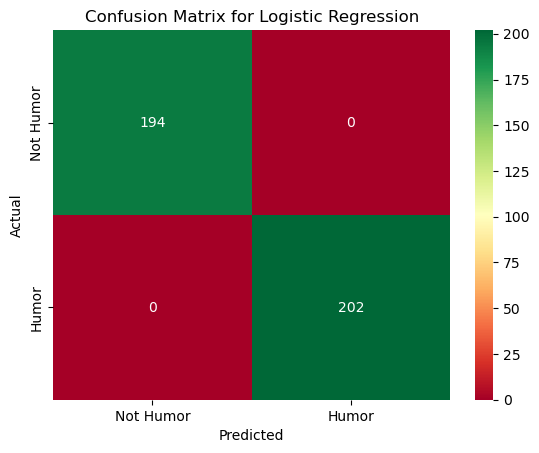

In [ ]:
# give a nice plot of the confusion matrix for logistic regression
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = results_df.loc['Logistic', 'best_estimator'].predict(X_test)
cm = confusion_matrix(y_test, y_pred)
# use a light red to dark green color map
sns.heatmap(cm, annot=True, fmt='d', cmap='RdYlGn')
# replace the labels with more meaningful names
plt.xticks([0.5, 1.5], ['Fake', 'Real'])
plt.yticks([0.5, 1.5], ['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

In [ ]:
# rerun just the winning logistic regression model with the full dataset and 5 fold cross validation
gs = GridSearchCV(pipeline, param_grid={**param_grid, **classifier_params['Logistic']}, cv=5, verbose=1,n_jobs=-1)
gs.fit(X, y)


In [108]:
# read in all of the results from the files in data/{size}results.csv
import os

uber_df = pd.DataFrame()
for file in os.listdir('data'):
    if 'results' in file:
        print(f'loading {file}')
        df = pd.read_csv(f'data/{file}')
        df['size'] = int(file.split('results')[0])
        uber_df = pd.concat([uber_df, df])

uber_df


loading 4950results.csv
loading 1980results.csv
loading 9900results.csv


,model,best_score,fit_time,best_params,best_estimator,size
0,Logistic,0.998990,10.535047,"{'classifier': LogisticRegression(C=10.0, max_...","Pipeline(steps=[('preprocess', LemmatizerStemm...",4950
1,Decision Tree,0.981566,9.747898,{'classifier': DecisionTreeClassifier(max_dept...,"Pipeline(steps=[('preprocess', LemmatizerStemm...",4950
2,Bayes,0.975505,9.496118,"{'classifier': MultinomialNB(alpha=0.1, fit_pr...","Pipeline(steps=[('preprocess', LemmatizerStemm...",4950
0,Logistic,0.996843,3.553469,"{'max_iter': 10000, 'C': 1.0, 'penalty': 'l1',...","Pipeline(steps=[('preprocess', LemmatizerStemm...",1980
1,Decision Tree,0.983586,3.764480,"{'max_depth': 20, 'criterion': 'gini', 'max_fe...","Pipeline(steps=[('preprocess', LemmatizerStemm...",1980
2,Bayes,0.970960,3.852549,"{'alpha': 0.1, 'preprocess': LemmatizerStemmer...","Pipeline(steps=[('preprocess', LemmatizerStemm...",1980
0,Logistic,0.998737,20.922753,"{'classifier': LogisticRegression(C=10.0, max_...","Pipeline(steps=[('preprocess', LemmatizerStemm...",9900
1,Decision Tree,0.976768,20.956969,{'classifier': DecisionTreeClassifier(criterio...,"Pipeline(steps=[('preprocess', LemmatizerStemm...",9900
2,Bayes,0.973737,20.876189,"{'classifier': MultinomialNB(alpha=0.1, fit_pr...","Pipeline(steps=[('preprocess', LemmatizerStemm...",9900


In [109]:
# make best_results dataframe from the uber_df sorted by Model and RMSE
best_results = uber_df.sort_values(by=['model', 'best_score']).groupby('model').first().reset_index()

#sort the best_results by RMSE from lowest to highest
best_results = best_results.sort_values(by='best_score')

# reindex the best_results dataframe using 'Model'
best_results = best_results.set_index('model')

best_results

,best_score,fit_time,best_params,best_estimator,size
model,,,,,
Bayes,0.970960,3.852549,"{'alpha': 0.1, 'preprocess': LemmatizerStemmer...","Pipeline(steps=[('preprocess', LemmatizerStemm...",1980
Decision Tree,0.976768,20.956969,{'classifier': DecisionTreeClassifier(criterio...,"Pipeline(steps=[('preprocess', LemmatizerStemm...",9900
Logistic,0.996843,3.553469,"{'max_iter': 10000, 'C': 1.0, 'penalty': 'l1',...","Pipeline(steps=[('preprocess', LemmatizerStemm...",1980


In [104]:
# show the coefs for the best model
coefs = results_df.loc['Logistic', 'best_estimator'].named_steps['classifier'].coef_[0]

# get the feature names
feature_names = results_df.loc['Logistic', 'best_estimator'].named_steps['vectorize'].get_feature_names_out()

# create a dataframe of the feature names and the coefs
coefs_df = pd.DataFrame({'feature': feature_names, 'coef': coefs})

# sort the dataframe by the coef
coefs_df = coefs_df.sort_values(by='coef')

# show the top 10 and bottom 10 features
print(coefs_df.head(10))
print(coefs_df.tail(10))


    feature       coef
176   getti -74.625307
153  featur -41.628968
469     via -34.546976
208    imag -28.653814
442      th -23.239762
180     gop -12.754772
233    know -10.911166
470   video -10.039372
129  donald  -7.506043
175     get  -7.362770
        feature        coef
163      follow    3.815722
184       great    5.973535
376      repres    6.071537
457       trade    6.469631
413       sourc    6.530537
268      market    6.550890
423   statement    9.783465
478  washington   11.431815
390        said   13.764796
382     reuters  181.702305


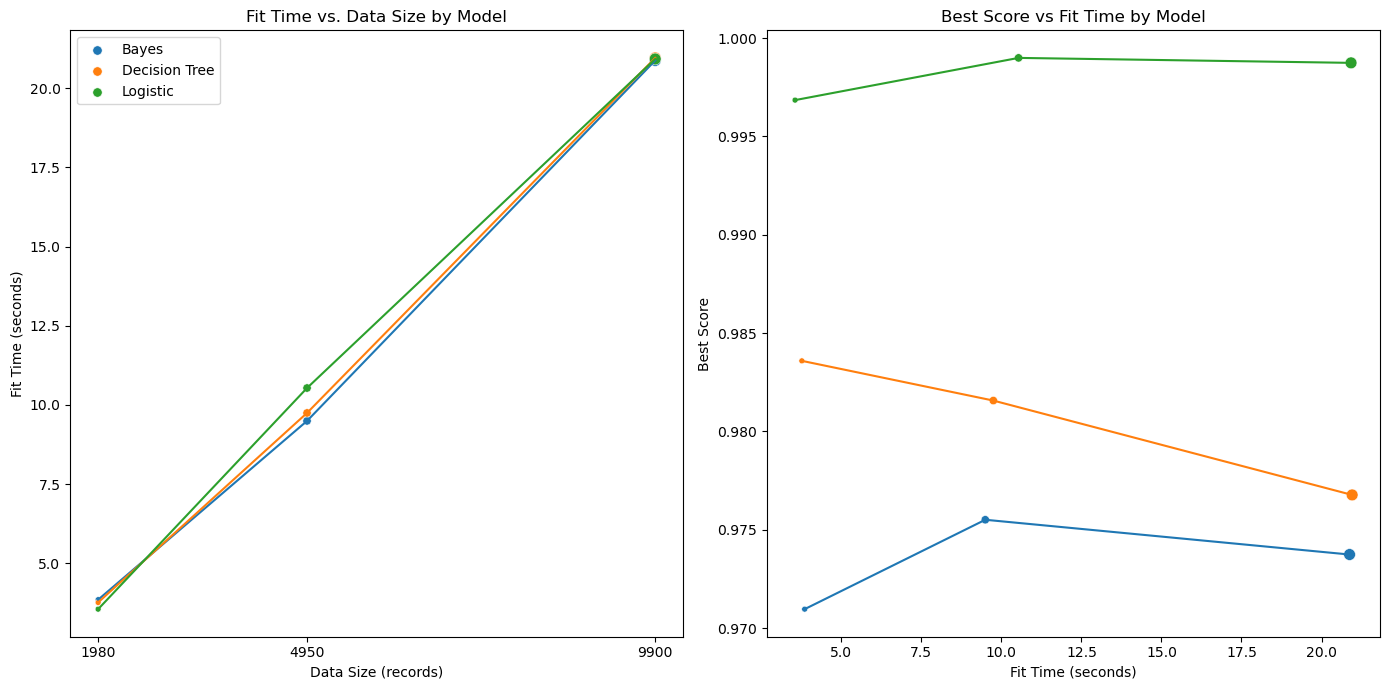

In [116]:

df = uber_df

# Normalize 'Data Size' for use as sizes in scatter plot
size_scale = {1980: 50, 4950: 100, 9900:200}  # Explicit sizes for each 'Data Size'
df['Size'] = df['size'].map(size_scale)

# Choose a palette
pal = sns.color_palette('tab10', n_colors=df['model'].nunique())

# Creating scatter and line plots
plt.figure(figsize=(14, 7))

# Plotting Training Time vs RMSE
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
for i, (name, group) in enumerate(df.groupby('model')):
    group = group.sort_values('size')
    sns.scatterplot(data=group, x='size', y='fit_time', size='Size', color=pal[i], label=name, legend=None)
    sns.lineplot(data=group, x='size', y='fit_time', color=pal[i])

plt.title('Fit Time vs. Data Size by Model')
plt.ylabel('Fit Time (seconds)')
plt.xlabel('Data Size (records)')

#only show x ticks for the actual sizes
plt.xticks([1980, 4950, 9900], ['1980', '4950', '9900'])
plt.legend()

# Plotting Training Time vs MAE
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
for i, (name, group) in enumerate(df.groupby('model')):
    group = group.sort_values('Size')
    sns.scatterplot(data=group, x='fit_time', y='best_score', size='Size', color=pal[i], label=name, legend=None)
    plt.plot(group['fit_time'], group['best_score'], color=pal[i])

plt.title('Best Score vs Fit Time by Model')
# plt.xscale('log')
# plt.yscale('log')
plt.xlabel('Fit Time (seconds)')
plt.ylabel('Best Score')

plt.tight_layout()
plt.show()